In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:

# --- 1. Configuration & Data Preparation ---

IMAGE_WIDTH = 28 * 3
IMAGE_HEIGHT = 28
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 1)

def create_three_digit_dataset():
    """
    A Python generator that creates a dataset of three-digit images on the fly.
    """
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = (train_images.astype(np.float32) - 127.5) / 127.5

    # Create a dictionary to quickly find images for each digit
    digit_indices = {i: np.where(train_labels == i)[0] for i in range(10)}

    while True:
        # Randomly select three digits
        digits = np.random.randint(0, 10, size=3)

        # Get a random image for each selected digit
        img1_idx = np.random.choice(digit_indices[digits[0]])
        img2_idx = np.random.choice(digit_indices[digits[1]])
        img3_idx = np.random.choice(digit_indices[digits[2]])

        img1 = train_images[img1_idx]
        img2 = train_images[img2_idx]
        img3 = train_images[img3_idx]

        # Concatenate the images horizontally
        composite_image = np.concatenate([img1, img2, img3], axis=1)
        composite_image = np.expand_dims(composite_image, axis=-1) # Add channel dimension

        yield composite_image, digits

def get_dataset_batch(batch_size=128):
    """
    Creates a batch of data using the generator.
    """
    image_generator = create_three_digit_dataset()

    def generator_wrapper():
        while True:
            images = []
            labels = []
            for _ in range(batch_size):
                img, label = next(image_generator)
                images.append(img)
                labels.append(label)

            labels = np.array(labels)
            yield np.array(images), [labels[:, 0], labels[:, 1], labels[:, 2]]

    return generator_wrapper()

# --- 2. Model Definitions ---

def make_generator_model():
    """
    Generator that takes noise and three digit inputs.
    """
    noise_input = layers.Input(shape=(100,))
    digit1_input = layers.Input(shape=(1,))
    digit2_input = layers.Input(shape=(1,))
    digit3_input = layers.Input(shape=(1,))

    d1_embedding = layers.Embedding(10, 50)(digit1_input)
    d2_embedding = layers.Embedding(10, 50)(digit2_input)
    d3_embedding = layers.Embedding(10, 50)(digit3_input)

    merged_embeddings = layers.Concatenate()([layers.Flatten()(d1_embedding), layers.Flatten()(d2_embedding), layers.Flatten()(d3_embedding)])

    concat = layers.Concatenate()([noise_input, merged_embeddings])

    x = layers.Dense(7 * 21 * 128, use_bias=False)(concat) # 7x(28*3/4)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 21, 128))(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return models.Model(inputs=[noise_input, digit1_input, digit2_input, digit3_input], outputs=output)

def make_discriminator_model():
    """
    Discriminator that takes a 28x84 image and three digit inputs.
    """
    image_input = layers.Input(shape=IMAGE_SHAPE)
    digit1_input = layers.Input(shape=(1,))
    digit2_input = layers.Input(shape=(1,))
    digit3_input = layers.Input(shape=(1,))

    d1_embedding = layers.Embedding(10, 50)(digit1_input)
    d2_embedding = layers.Embedding(10, 50)(digit2_input)
    d3_embedding = layers.Embedding(10, 50)(digit3_input)

    merged_embeddings = layers.Concatenate()([layers.Flatten()(d1_embedding), layers.Flatten()(d2_embedding), layers.Flatten()(d3_embedding)])

    dense_embedding = layers.Dense(IMAGE_WIDTH * IMAGE_HEIGHT)(merged_embeddings)
    reshaped_embedding = layers.Reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 1))(dense_embedding)

    concat = layers.Concatenate()([image_input, reshaped_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concat)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    return models.Model(inputs=[image_input, digit1_input, digit2_input, digit3_input], outputs=output)


# --- 3. Loss Functions & Optimizers ---
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)


# --- 4. Training Step & Visualization ---
@tf.function
def train_step(images, labels, generator, discriminator):
    noise = tf.random.normal([tf.shape(images)[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise] + labels, training=True)

        real_output = discriminator([images] + labels, training=True)
        fake_output = discriminator([generated_images] + labels, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    grads_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_display_image(generator, epoch):
    """
    Generates and displays one random 3-digit number image.
    """
    noise = tf.random.normal([1, 100])
    random_digits = np.random.randint(0, 10, size=3)

    d1 = tf.constant([[random_digits[0]]])
    d2 = tf.constant([[random_digits[1]]])
    d3 = tf.constant([[random_digits[2]]])

    prediction = generator([noise, d1, d2, d3], training=False)

    plt.imshow(prediction[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.title(f'Epoch {epoch+1} - Generated Number: {random_digits[0]}{random_digits[1]}{random_digits[2]}')
    plt.axis('off')
    plt.show()

# --- 5. Main Training Loop ---
def train(generator, discriminator, epochs=200, steps_per_epoch=100):
    dataset_generator = get_dataset_batch()

    print("Starting Training...")
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images, labels = next(dataset_generator)
            g_loss, d_loss = train_step(images, labels, generator, discriminator)

            if (step + 1) % 50 == 0:
                print(f"Epoch {epoch+1}, Step {step+1}: Gen Loss={g_loss:.4f}, Disc Loss={d_loss:.4f}")

        clear_output(wait=True)
        generate_and_display_image(generator, epoch)

    print("Training finished.")



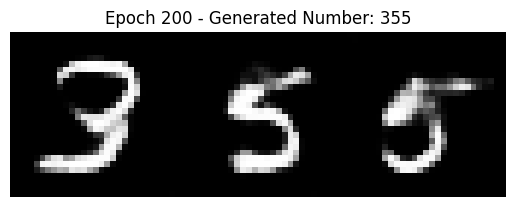

Training finished.


In [3]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# NOTE: Training this model is computationally intensive and will take a long time.
# Adjust epochs and steps_per_epoch for your hardware.
train(generator, discriminator, epochs=200, steps_per_epoch=200)
